In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TE_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import seaborn as sns

import re
import string

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import precision_recall_fscore_support, average_precision_score, accuracy_score, \
                            precision_score, recall_score, f1_score, classification_report, precision_recall_curve

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model, Sequential

Carico il dataset

In [11]:
df = pd.read_csv('../data/Filter_Toxic_Comments_dataset.csv')

# Osservazione dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   comment_text   159571 non-null  object
 1   toxic          159571 non-null  int64 
 2   severe_toxic   159571 non-null  int64 
 3   obscene        159571 non-null  int64 
 4   threat         159571 non-null  int64 
 5   insult         159571 non-null  int64 
 6   identity_hate  159571 non-null  int64 
 7   sum_injurious  159571 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 9.7+ MB


Il dataset non ha problematica

In [ ]:
df.head(10)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0
5,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,4
7,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,0
8,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,0
9,alignment on this subject and which are contra...,0,0,0,0,0,0,0


Il dataset è composto da 8 colonne: c'è la colonna dei commenti da analizzare, le colonne, da 1-6, che etichettano in binario quale falvor di insulto ha il commento, ed infine una colonna di recap

Vediamo quanti dei commenti sono classificabili come come negativi

In [ ]:
print(f"\033[92mCommenti negativi nel dataset: {(df['sum_injurious'] != 0).sum()}\033[0m")

Commenti negativi nel dataset: 16225


il dataset si presenta fortemente sbilanciato. Vediamo inoltre come tra i commenti negativi risultano essere distribuiti le categorie

In [ ]:
print(f'\033[92m{df.loc[:, "toxic":"identity_hate"].sum()}\033[0m')

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


anche tra le label target è presente uno sbilanciamento.

# Preprocessing

Faccio una normalizzazione sui commenti

In [ ]:
def normalize_text(text):
    # 1. Lowercase
    text = text.lower()
    # 2. Rimuovi URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # 3. Rimuovi menzioni
    text = re.sub(r'@\w+', '', text)
    # 4. Rimuovi spazi multipli
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
df['comment_text'] = [normalize_text(c) for c in df['comment_text']]
#x = np.array(x)
df['comment_text'].shape

(159571,)

# Modello

## Modello classificazione binaria (hate or not hate)



Visto il dataset sbilanciato e multilabel, decido di procedere con un approccio "Two-Stage Classification", con il primo modello determino se un commento è negaitivo (quindi se sum_injurious $\geq$ 1) mentre con il secondo, nel caso di commento negativo, determino a quale label è possibile associarlo

In [ ]:
df['has_hate'] = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].any(axis = 1).astype(int)
df.head(10)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious,has_hate
0,explanation why the edits made under my userna...,0,0,0,0,0,0,0,0
1,d'aww! he matches this background colour i'm s...,0,0,0,0,0,0,0,0
2,"hey man, i'm really not trying to edit war. it...",0,0,0,0,0,0,0,0
3,""" more i can't make any real suggestions on im...",0,0,0,0,0,0,0,0
4,"you, sir, are my hero. any chance you remember...",0,0,0,0,0,0,0,0
5,""" congratulations from me as well, use the too...",0,0,0,0,0,0,0,0
6,cocksucker before you piss around on my work,1,1,1,0,1,0,4,1
7,your vandalism to the matt shirvington article...,0,0,0,0,0,0,0,0
8,sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,0,0
9,alignment on this subject and which are contra...,0,0,0,0,0,0,0,0


In [ ]:
x = df.comment_text.values
y_hate = df.loc[:, 'has_hate']
print(f'\033[92mCommenti con hating: {100*y_hate.sum()/len(y_hate):.1f}%\033[0m')
print(f'\033[92m{x.shape} {y_hate.shape}\033[0m')

Commenti con hating: 10.2%
(159571,) (159571,)


Procediamo prima con la classificazione binaria del commento

In [ ]:
x_train_hate, x_test_hate, y_train_hate, y_test_hate = train_test_split(x, y_hate, test_size = 0.2, random_state = 1, stratify = y_hate, shuffle = True)

In [ ]:
tokenizer_hate = Tokenizer()
tokenizer_hate.fit_on_texts(x_train_hate)
print(f'\033[92mNumero di commeti processati: {tokenizer_hate.document_count}\033[0m')

train_hate_sequences = tokenizer_hate.texts_to_sequences(x_train_hate)
test_hate_sequences = tokenizer_hate.texts_to_sequences(x_test_hate)

vocabulary_hate_size = len(tokenizer_hate.word_counts) + 1 # quel + 1 serve per il padding
print(f'\033[92mGrandezza del vocabolario: {vocabulary_hate_size}\033[0m')

max_len_hate = len(max(train_hate_sequences, key = len))
print(f'\033[92mLunghezza massima della sequenza di train: {max_len_hate}\033[0m')

Numero di commeti processati: 127656
Grandezza del vocabolario: 175438
Lunghezza massima della sequenza di train: 1403


Paddo i set di training e di testing rispetto al max_len_hate

In [ ]:
padded_train_hate_sequences = pad_sequences(sequences = train_hate_sequences, maxlen = max_len_hate)
padded_test_hate_sequences = pad_sequences(sequences = test_hate_sequences, maxlen = max_len_hate)

Ci aspettiamo che le sequenze paddate siano delle matrici (n_samples $\times$ max_len)

In [ ]:
print(f'\033[92mTrain set: {padded_train_hate_sequences.shape}\033[0m')
print(f'\033[92mTest set: {padded_test_hate_sequences.shape}\033[0m')

Train set: (127656, 1403)
Test set: (31915, 1403)


Costruiamo ora il modello con un solo layer BiLSTM e uno strato denso, facendo varie prove ho avuto modo di osservare che altre architetture non portano miglioramenti, anzi, ma solo tempo di calcolo elevato

In [ ]:
class CSVLoggerCustom(tf.keras.callbacks.Callback):
    def __init__(self, filename):
        super().__init__()
        self.filename = filename
        self.file = open(self.filename, 'w', newline='')
        self.writer = None

    def on_train_begin(self, logs=None):
        self.writer = csv.writer(self.file)
        self.writer.writerow(['epoch', 'loss', 'accuracy', 'auc', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_auc', 'val_precision', 'val_recall'])

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        row = [epoch + 1,
               logs.get('loss'),
               logs.get('accuracy'),
               logs.get('auc'),
               logs.get('precision'),
               logs.get('recall'),
               logs.get('val_loss'),
               logs.get('val_accuracy'),
               logs.get('val_auc'),
               logs.get('val_precision'),
               logs.get('val_recall'),]
        self.writer.writerow(row)
        self.file.flush()

    def on_train_end(self, logs=None):
        self.file.close()


Definisco la callback per il modello binary

In [ ]:
def callback_binary_hate():

  reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss',  # o 'val_auc' ecc.
                                           factor = 0.7,          # riduci LR del 30%
                                           patience = 2,          # aspetta 2 epoche senza miglioramento
                                           min_lr = 1e-6,         # non andare sotto questo valore
                                           verbose = 0)           # stampa i cambiamenti

  early_stop = EarlyStopping(monitor = 'val_loss',         # metrica da monitorare
                             patience = 7,                 # quante epoche aspettare prima di fermarsi
                             restore_best_weights = True,  # ripristina i pesi migliori
                             verbose = 1)

  checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/Deep Learning/model_hate_binary.h5',
                               monitor = 'val_loss',
                               save_best_only = True,
                               save_weights_only = False,
                               verbose = 1)

  return early_stop, checkpoint, reduce_learning_rate

Bilancio il dataset calcolando i pesi delle due classi

In [ ]:
def class_weights_hate(y_train):

  class_weights_hate = class_weight.compute_class_weight(class_weight = 'balanced',
                                                         classes = np.unique(y_train),
                                                         y = y_train)

  class_weights_hate = dict(enumerate(class_weights_hate))

  return class_weights_hate

Definisco il modello binary

In [ ]:
def binary_hate_model(vocabulary_size, max_len, dropout, optimizer, loss, metrics):

  model = Sequential()
  model.add(Embedding(input_dim = vocabulary_size, output_dim = 128, input_length = max_len))

  #
  model.add(Bidirectional(LSTM(32, return_sequences=False, activation='tanh')))
  model.add(BatchNormalization())
  model.add(Dropout(dropout))

  #
  model.add(Dense(16, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(dropout))

  model.add(Dense(units = 1, activation = 'sigmoid'))
  model.build(input_shape = (None, max_len))

  model.compile(optimizer = optimizer,
                loss = loss,
                metrics = metrics)

  return model

In [ ]:
clear_session()
model_hate_binary = binary_hate_model(vocabulary_size = vocabulary_hate_size,
                                      max_len = max_len_hate,
                                      dropout = 0.3,
                                      optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-2),
                                      loss = 'binary_crossentropy',
                                      metrics = ['accuracy',
                                                 tf.keras.metrics.AUC(name = 'auc', multi_label=False),
                                                 tf.keras.metrics.Precision(name = 'precision'),
                                                 tf.keras.metrics.Recall(name = 'recall')])
model_hate_binary.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1403, 128)      │    22,456,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,498,657 (85.83 MB)

 Trainable params: 22,498,497 (85.82 MB)

 Non-trainable params: 160 (640.00 B)

Salvo nel drive il resoconto delle metrice per ogni epoca

In [ ]:
csv_logger = CSVLoggerCustom('/content/drive/MyDrive/Colab Notebooks/Deep Learning/log_model_hate_or_not.csv')

history_hate_binary = model_hate_binary.fit(padded_train_hate_sequences,
                                            y_train_hate,
                                            epochs = 100,
                                            validation_split = 0.2,
                                            batch_size = 256,
                                            class_weight = class_weights_hate(y_test_hate),
                                            callbacks = [callback_binary_hate(), csv_logger])

Epoch 1/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.8225 - auc: 0.8888 - loss: 0.4043 - precision: 0.3643 - recall: 0.8045
Epoch 1: val_loss improved from inf to 0.11138, saving model to model_hate_binary.h5


399/399 ━━━━━━━━━━━━━━━━━━━━ 61s 144ms/step - accuracy: 0.8227 - auc: 0.8890 - loss: 0.4041 - precision: 0.3646 - recall: 0.8047 - val_accuracy: 0.9622 - val_auc: 0.9737 - val_loss: 0.1114 - val_precision: 0.8241 - val_recall: 0.7863 - learning_rate: 0.0100
Epoch 2/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9431 - auc: 0.9842 - loss: 0.1571 - precision: 0.6561 - recall: 0.9437
Epoch 2: val_loss did not improve from 0.11138
399/399 ━━━━━━━━━━━━━━━━━━━━ 56s 140ms/step - accuracy: 0.9431 - auc: 0.9842 - loss: 0.1571 - precision: 0.6561 - recall: 0.9437 - val_accuracy: 0.9173 - val_auc: 0.9732 - val_loss: 0.2237 - val_precision: 0.5489 - val_recall: 0.9220 - learning_rate: 0.0100
Epoch 3/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9623 - auc: 0.9922 - loss: 0.1041 - precision: 0.7388 - recall: 0.9666
Epoch 3: val_loss did not improve from 0.11138
399/399 ━━━━━━━━━━━━━━━━━━━━ 56s 141ms/step - accuracy: 0.9623 - auc: 0.9922 - loss: 0.1041 - precision: 0.738

Valuto il modello appena addestrato sul set di test

In [ ]:
model_hate_binary.evaluate(padded_test_hate_sequences,y_test_hate)

998/998 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.9611 - auc: 0.9748 - loss: 0.1136 - precision: 0.8243 - recall: 0.7809


[0.11243551224470139,
 0.961742103099823,
 0.9739313125610352,
 0.8275080919265747,
 0.7879815101623535]

## Modello classificazione multilabel

Addestro un modello per distinguere il tipo di hating. Selezioniamo tutti i commenti negativi, quindi con sum_injurious $\geq$ 1

In [ ]:
df_hate_type = df[df["has_hate"] == 1]

In [ ]:
x_hate_type = df_hate_type.comment_text.values
y_hate_type = df_hate_type.loc[:, 'toxic':'identity_hate']

print(f'\033[92m{x_hate_type.shape}\033[0m')
print(f'\033[92m{y_hate_type.shape}\033[0m')

(16225,)
(16225, 6)


Osservo la distribuzione delle labels

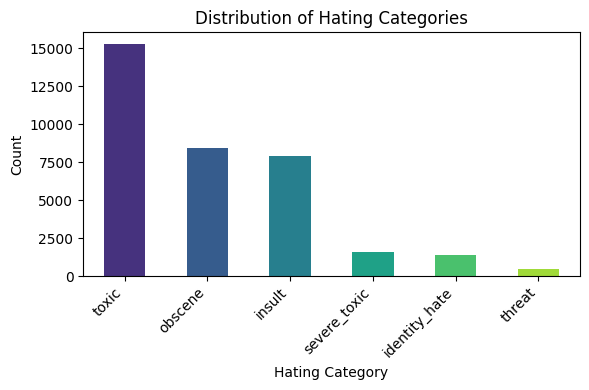

In [ ]:
class_counts = y_hate_type.sum().sort_values(ascending=False)

plt.figure(figsize=(6, 4))
class_counts.plot(kind='bar', color=sns.color_palette('viridis', len(class_counts)))
plt.title('Distribution of Hating Categories')
plt.xlabel('Hating Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

si osserva un forte sbilanciamento, quindi si procedera come nel caso binario, ma con piu classi

In [ ]:
x_train_hate_type, x_test_hate_type, y_train_hate_type, y_test_hate_type = train_test_split(x_hate_type ,y_hate_type, test_size = 0.2, random_state = 1, shuffle = True)

In [ ]:
tokenizer_hate_type = Tokenizer()
tokenizer_hate_type.fit_on_texts(x_train_hate_type)
print(f'\033[92mNumero di commetini processati: {tokenizer_hate_type.document_count}\033[0m')

train_hate_type_sequences = tokenizer_hate_type.texts_to_sequences(x_train_hate_type)
test_hate_type_sequences = tokenizer_hate_type.texts_to_sequences(x_test_hate_type)

vocabulary_size_hate_type = len(tokenizer_hate_type.word_counts) + 1 # quel +1 serve per il padding
print(f'\033[92mGrandezza del vocabolario: {vocabulary_size_hate_type}\033[0m')

max_len_hate_type = len(max(train_hate_type_sequences, key = len))
print(f'\033[92mLunghezza massima della sequenza di train: {max_len_hate_type}\033[0m')

Numero di commetini processati: 12980
Grandezza del vocabolario: 32083
Lunghezza massima della sequenza di train: 1356


In [ ]:
padded_train_hate_type_sequences = pad_sequences(sequences = train_hate_type_sequences, maxlen = max_len_hate_type)
padded_test_hate_type_sequences = pad_sequences(sequences = test_hate_type_sequences, maxlen = max_len_hate_type)

In [ ]:
padded_train_hate_type_sequences.shape, y_train_hate_type.shape

((12980, 1356), (12980, 6))

In [ ]:
print(f'\033[92mTrain set: {padded_train_hate_type_sequences.shape}\033[0m')
print(f'\033[92mTest set: {padded_test_hate_type_sequences.shape}\033[0m')

Train set: (12980, 1356)
Test set: (3245, 1356)


Definisco la callback per il modello multilabels

In [ ]:
def callback_hate_type():

  reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss',    # o 'val_auc' ecc.
                                           factor = 0.75,            # riduci LR del 20%
                                           patience = 5,            # aspetta 2 epoche senza miglioramento
                                           min_lr = 1e-6,           # non andare sotto questo valore
                                           verbose = 0)             # stampa i cambiamenti

  early_stop = EarlyStopping(monitor = 'val_loss',         # metrica da monitorare
                             patience = 20,                # quante epoche aspettare prima di fermarsi
                             restore_best_weights = True,  # ripristina i pesi migliori
                             verbose = 1)

  checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/Deep Learning/model_hate_type.h5',
                               monitor = 'val_loss',
                               save_best_only = True,
                               save_weights_only = False,
                               verbose = 1)

  return early_stop, checkpoint#, reduce_learning_rate

Calcolo la cross entropy loss pesata per tutte le 6 labels

In [ ]:
def compute_class_weights(y_train):
    class_counts = np.sum(y_train, axis=0)
    class_freq = class_counts / y_train.shape[0]
    weights = 1.0 / class_freq
    weights = weights / np.sum(weights) * len(weights)  # optional normalization
    return weights

weights_tensor = tf.constant(compute_class_weights(y_train_hate_type), dtype=tf.float32)
print(f'\033[92mPesi delle classi: {weights_tensor}\033[0m')

def weighted_binary_crossentropy(y_true, y_pred):
    bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
    return tf.reduce_sum(bce * weights_tensor, axis=-1)

Pesi delle classi: [0.10431261 0.99826926 0.18859474 3.3511455  0.20221514 1.1554629 ]


Definisco il modello

In [ ]:
def hate_type_model(vocabulary_size, max_len, dropout, optimizer, loss, metrics):

  model = Sequential()
  model.add(Embedding(input_dim = vocabulary_size, output_dim = 256, input_length = max_len))

  model.add(Bidirectional(LSTM(units = 256, activation = 'tanh', name='lstm_layer')))
  model.add(BatchNormalization(name='batch_norm_1'))
  model.add(Dropout(dropout, name='dropout_1'))

  model.add(Dense(units = 128, activation = 'relu', name='dense_1'))
  model.add(BatchNormalization(name='batch_norm_2'))
  model.add(Dropout(dropout, name='dropout_2'))

  model.add(Dense(units = 6, activation = 'sigmoid', name='output_dense'))

  model.build(input_shape = (None, max_len))

  model.compile(optimizer = optimizer,
                loss = loss,
                metrics = metrics)

  return model

In [ ]:
clear_session()
model_hate_type = hate_type_model(vocabulary_size = vocabulary_size_hate_type,
                                  max_len = max_len_hate_type,
                                  dropout = 0.2,
                                  optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-4),
                                  loss = weighted_binary_crossentropy,
                                  metrics = ['accuracy',
                                             tf.keras.metrics.AUC(name = 'auc', multi_label=True),
                                             tf.keras.metrics.Precision(name = 'precision'),
                                             tf.keras.metrics.Recall(name = 'recall')])
model_hate_type.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1356, 256)      │     8,213,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_4                    │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,332,870 (35.60 MB)

 Trainable params: 9,331,590 (35.60 MB)

 Non-trainable params: 1,280 (5.00 KB)

Fitto il modello e copio in un file csv le principali metriche del modello per ogni epoca

In [ ]:
csv_logger = CSVLoggerCustom('/content/drive/MyDrive/Colab Notebooks/Deep Learning/log_model_hate_type.csv')

history_hate_type = model_hate_type.fit(padded_train_hate_type_sequences,
                                        y_train_hate_type,
                                        epochs = 100,
                                        validation_split = 0.2,
                                        batch_size = 64,
                                        callbacks = [callback_hate_type(), csv_logger])

Epoch 1/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.1876 - auc: 0.5264 - loss: 5.0153 - precision: 0.3743 - recall: 0.5095
Epoch 1: val_loss improved from inf to 3.63896, saving model to /content/drive/MyDrive/Colab Notebooks/Deep Learning/model_hate_type.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 147ms/step - accuracy: 0.1877 - auc: 0.5264 - loss: 5.0135 - precision: 0.3744 - recall: 0.5095 - val_accuracy: 0.0401 - val_auc: 0.5723 - val_loss: 3.6390 - val_precision: 0.5763 - val_recall: 0.3005
Epoch 2/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.2100 - auc: 0.5702 - loss: 4.1509 - precision: 0.4183 - recall: 0.5312
Epoch 2: val_loss improved from 3.63896 to 3.02915, saving model to /content/drive/MyDrive/Colab Notebooks/Deep Learning/model_hate_type.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 140ms/step - accuracy: 0.2101 - auc: 0.5703 - loss: 4.1501 - precision: 0.4183 - recall: 0.5312 - val_accuracy: 0.0724 - val_auc: 0.6237 - val_loss: 3.0291 - val_precision: 0.6423 - val_recall: 0.3942
Epoch 3/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.2436 - auc: 0.6124 - loss: 3.6367 - precision: 0.4651 - recall: 0.5602
Epoch 3: val_loss improved from 3.02915 to 2.44039, saving model to /content/drive/MyDrive/Colab Notebooks/Deep Learning/model_hate_type.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 141ms/step - accuracy: 0.2437 - auc: 0.6124 - loss: 3.6360 - precision: 0.4652 - recall: 0.5602 - val_accuracy: 0.2727 - val_auc: 0.6570 - val_loss: 2.4404 - val_precision: 0.6742 - val_recall: 0.5580
Epoch 4/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.2833 - auc: 0.6541 - loss: 3.1783 - precision: 0.5249 - recall: 0.5900
Epoch 4: val_loss did not improve from 2.44039
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 127ms/step - accuracy: 0.2834 - auc: 0.6541 - loss: 3.1777 - precision: 0.5250 - recall: 0.5900 - val_accuracy: 0.3282 - val_auc: 0.7103 - val_loss: 2.9974 - val_precision: 0.5964 - val_recall: 0.7475
Epoch 5/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.3310 - auc: 0.6936 - loss: 2.7629 - precision: 0.5932 - recall: 0.6250
Epoch 5: val_loss did not improve from 2.44039
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 128ms/step - accuracy: 0.3311 - auc: 0.6936 - loss: 2.7623 - precision: 0.5933 - recall: 0.6250 - val_accuracy: 0.2870 - val_

163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 140ms/step - accuracy: 0.3989 - auc: 0.7351 - loss: 2.3643 - precision: 0.6604 - recall: 0.6706 - val_accuracy: 0.4927 - val_auc: 0.7237 - val_loss: 1.8667 - val_precision: 0.6843 - val_recall: 0.7934
Epoch 7/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.4634 - auc: 0.7589 - loss: 2.0326 - precision: 0.7132 - recall: 0.7017
Epoch 7: val_loss improved from 1.86668 to 1.69382, saving model to /content/drive/MyDrive/Colab Notebooks/Deep Learning/model_hate_type.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 139ms/step - accuracy: 0.4635 - auc: 0.7588 - loss: 2.0322 - precision: 0.7132 - recall: 0.7018 - val_accuracy: 0.6121 - val_auc: 0.7186 - val_loss: 1.6938 - val_precision: 0.7522 - val_recall: 0.7855
Epoch 8/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.5201 - auc: 0.7687 - loss: 1.7253 - precision: 0.7564 - recall: 0.7371
Epoch 8: val_loss improved from 1.69382 to 1.29951, saving model to /content/drive/MyDrive/Colab Notebooks/Deep Learning/model_hate_type.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 140ms/step - accuracy: 0.5203 - auc: 0.7688 - loss: 1.7250 - precision: 0.7565 - recall: 0.7371 - val_accuracy: 0.7273 - val_auc: 0.7393 - val_loss: 1.2995 - val_precision: 0.8106 - val_recall: 0.7699
Epoch 9/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.5859 - auc: 0.7994 - loss: 1.4802 - precision: 0.7872 - recall: 0.7734
Epoch 9: val_loss did not improve from 1.29951
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 128ms/step - accuracy: 0.5860 - auc: 0.7994 - loss: 1.4798 - precision: 0.7872 - recall: 0.7734 - val_accuracy: 0.3263 - val_auc: 0.7362 - val_loss: 1.9039 - val_precision: 0.6142 - val_recall: 0.9246
Epoch 10/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.6258 - auc: 0.8096 - loss: 1.2554 - precision: 0.8150 - recall: 0.7920
Epoch 10: val_loss did not improve from 1.29951
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 128ms/step - accuracy: 0.6259 - auc: 0.8096 - loss: 1.2552 - precision: 0.8150 - recall: 0.7920 - val_accuracy: 0.6471 - va

163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 142ms/step - accuracy: 0.6718 - auc: 0.8289 - loss: 1.0739 - precision: 0.8316 - recall: 0.8028 - val_accuracy: 0.8297 - val_auc: 0.7444 - val_loss: 1.2810 - val_precision: 0.8504 - val_recall: 0.6694
Epoch 12/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.6960 - auc: 0.8413 - loss: 0.9395 - precision: 0.8423 - recall: 0.8285
Epoch 12: val_loss improved from 1.28100 to 1.17086, saving model to /content/drive/MyDrive/Colab Notebooks/Deep Learning/model_hate_type.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 140ms/step - accuracy: 0.6960 - auc: 0.8413 - loss: 0.9395 - precision: 0.8423 - recall: 0.8285 - val_accuracy: 0.8116 - val_auc: 0.7690 - val_loss: 1.1709 - val_precision: 0.7810 - val_recall: 0.8038
Epoch 13/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.7208 - auc: 0.8584 - loss: 0.8237 - precision: 0.8521 - recall: 0.8404
Epoch 13: val_loss did not improve from 1.17086
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.7209 - auc: 0.8583 - loss: 0.8237 - precision: 0.8521 - recall: 0.8404 - val_accuracy: 0.7935 - val_auc: 0.7595 - val_loss: 1.1918 - val_precision: 0.8297 - val_recall: 0.7597
Epoch 14/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.7339 - auc: 0.8640 - loss: 0.7360 - precision: 0.8554 - recall: 0.8465
Epoch 14: val_loss did not improve from 1.17086
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.7339 - auc: 0.8640 - loss: 0.7360 - precision: 0.8554 - recall: 0.8465 - val_accuracy: 0.8987 - 

In [ ]:
model_hate_type.evaluate(padded_test_hate_type_sequences, y_test_hate_type)

102/102 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.8163 - auc: 0.7652 - loss: 1.3447 - precision: 0.7846 - recall: 0.7934


[1.276807427406311,
 0.8141756653785706,
 0.7588304877281189,
 0.776339590549469,
 0.795833945274353]

# Validazione

Carico i modelli salvati

In [ ]:
# Carica il modello di classificazione binario
try:
  model_hate_binary = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Deep Learning/model_hating_or_not.h5')
  print("Modello 'model_hate_binary.h5' caricato con successo.")
except Exception as e:
  print(f"Errore nel caricamento del modello binario: {e}")

# Carica il modello di classificazione multilabel
try:
  model_hate_type = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Deep Learning/model_hate_type.h5',
                                              custom_objects={'weighted_binary_crossentropy': weighted_binary_crossentropy}) # Add custom_objects if you saved with a custom loss
  print("Modello 'model_hate_type.h5' caricato con successo.")
except Exception as e:
  print(f"Errore nel caricamento del modello multilabel: {e}")

Modello 'model_hate_binary.h5' caricato con successo.


Modello 'model_hate_type.h5' caricato con successo.


Faccio la predizione di probabilita sul set di test. Procedo prima con la classificazione binaria, dove stimo il threshold che massimizza la F1-score

In [ ]:
y_test_pred_hate = model_hate_binary.predict(padded_test_hate_sequences)

998/998 ━━━━━━━━━━━━━━━━━━━━ 31s 30ms/step


In [ ]:
precision_bin, recall_bin, thresholds_bin = precision_recall_curve(y_test_hate, y_test_pred_hate)

# Escludiamo l'ultimo valore di precision e recall che corrisponde a un threshold non definito, visto si ha recall = 0
f1_scores_bin = (2 * precision_bin[:-1] * recall_bin[:-1]) / (precision_bin[:-1] + recall_bin[:-1])
f1_scores_bin[np.isnan(f1_scores_bin)] = 0

optimal_threshold_binary = thresholds_bin[np.argmax(f1_scores_bin)]

print(f"\033[92mThreshold ottimale per la classificazione binaria (massimizzando l'F1-score): {optimal_threshold_binary:.3f}\033[0m")

Threshold ottimale per la classificazione binaria (massimizzando l'F1-score): 0.542


In [ ]:
# --- Valutazione del modello binario con il threshold ottimale ---

y_pred_binary_classes = (y_test_pred_hate >= optimal_threshold_binary).astype(int).flatten()

accuracy_bin = accuracy_score(y_test_hate, y_pred_binary_classes)
precision_bin_opt = precision_score(y_test_hate, y_pred_binary_classes, zero_division=0)
recall_bin_opt = recall_score(y_test_hate, y_pred_binary_classes, zero_division=0)
f1_bin_opt = f1_score(y_test_hate, y_pred_binary_classes, zero_division=0)

print("\n\033[92mRisultati del modello binario sul set di test con threshold ottimale:\033[0m")
print(f"\033[92mAccuracy: {accuracy_bin:.3f}\033[0m")
print(f"\033[92mPrecision: {precision_bin_opt:.3f}\033[0m")
print(f"\033[92mRecall: {recall_bin_opt:.3f}\033[0m")
print(f"\033[92mF1-Score: {f1_bin_opt:.3f}\033[0m")


Risultati del modello binario sul set di test con threshold ottimale:
Accuracy: 0.962
Precision: 0.841
Recall: 0.777
F1-Score: 0.807


Poi passo al modello multilabels, in maniera analoga

In [ ]:
y_pred_multi = model_hate_type.predict(padded_test_hate_type_sequences)
y_true_multi = y_test_hate_type.values

102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step


In [ ]:
optimal_thresholds_multilabel = {}
labels = y_test_hate_type.columns

print("\n\033[92mThresholds ottimali per la classificazione multilabel (massimizzando l'F1-score per ogni classe sull'intero set di test multilabel):\033[0m")

for i, label in enumerate(labels):
    precision_multi, recall_multi, thresholds_multi = precision_recall_curve(y_true_multi[:, i], y_pred_multi[:, i])
    # Escludiamo l'ultimo valore di precision e recall che corrisponde a un threshold non definito
    f1_scores_multi = (2 * precision_multi[:-1] * recall_multi[:-1]) / (precision_multi[:-1] + recall_multi[:-1])
    f1_scores_multi[np.isnan(f1_scores_multi)] = 0 # Handle NaN values

    optimal_threshold = thresholds_multi[np.argmax(f1_scores_multi)]

    optimal_thresholds_multilabel[label] = optimal_threshold
    print(f"\033[92m{label}: {optimal_threshold:.3f}\033[0m")


Thresholds ottimali per la classificazione multilabel (massimizzando l'F1-score per ogni classe sull'intero set di test multilabel):
toxic: 0.321
severe_toxic: 0.655
obscene: 0.332
threat: 0.218
insult: 0.335
identity_hate: 0.124


In [ ]:
print("\n\033[92mRisultati multilabel sull'intero set di test multilabel con thresholds ottimali:\033[0m")
print("")

n_classes = y_true_multi.shape[1]
metrics_data = []
for i in range(n_classes):
    label = y_test_hate_type.columns[i]
    optimal_threshold = optimal_thresholds_multilabel[label]

    y_pred_multi_binary = (y_pred_multi[:, i] >= optimal_threshold).astype(int)

    acc = accuracy_score(y_true_multi[:, i], y_pred_multi_binary)
    prec = precision_score(y_true_multi[:, i], y_pred_multi_binary, zero_division = 0)
    rec = recall_score(y_true_multi[:, i], y_pred_multi_binary, zero_division = 0)
    f1 = f1_score(y_true_multi[:, i], y_pred_multi_binary, zero_division = 0)
    metrics_data.append({'Classe': label,
                         'Accuracy': acc,
                         'Precision': prec,
                         'Recall': rec,
                         'F1': f1})

metrics_df = pd.DataFrame(metrics_data)
display(metrics_df)

y_pred_multi_binary_all_labels = (y_pred_multi >= np.array([optimal_thresholds_multilabel[label] for label in labels])).astype(int)
micro_prec = precision_score(y_true_multi.flatten(), y_pred_multi_binary_all_labels.flatten(), average='micro', zero_division=0)
print("")
print(f"\033[92mPrecisione globale (sull'intero set di test multilabel): {micro_prec:.3f}\033[0m")


Risultati multilabel sull'intero set di test multilabel con thresholds ottimali:



,Classe,Accuracy,Precision,Recall,F1
0,toxic,0.941140,0.941140,1.000000,0.969678
1,severe_toxic,0.896764,0.467128,0.427215,0.446281
2,obscene,0.677042,0.646132,0.830852,0.726941
3,threat,0.964869,0.412371,0.412371,0.412371
4,insult,0.621263,0.573698,0.831734,0.679028
5,identity_hate,0.869954,0.346734,0.460000,0.395415



Precisione globale (sull'intero set di test multilabel): 0.829


# Inferenza e Predizione

Passo in input qualche commento e vedo come classifica il modello

In [ ]:
def predict_hate_pipeline_readable(comment_texts,
                                   tokenizer_hate,
                                   model_hate_binary,
                                   tokenizer_hate_type,
                                   model_hate_type,
                                   max_len_hate,
                                   max_len_hate_type,
                                   threshold_binary,
                                   thresholds_multilabel,
                                   labels = ['Toxic', 'Severely Toxic', 'Obscene', 'Threat', 'Insult', 'Identity Hate']):

    seq_bin = tokenizer_hate.texts_to_sequences(comment_texts)
    padded_bin = tf.keras.preprocessing.sequence.pad_sequences(seq_bin, maxlen=max_len_hate)
    preds_bin = model_hate_binary.predict(padded_bin)
    is_hate = (preds_bin >= threshold_binary).astype(int).flatten()

    results = []
    hate_indices = np.where(is_hate == 1)[0]

    multilabel_preds = np.zeros((len(comment_texts), len(labels)), dtype=int)

    if len(hate_indices) > 0:
        hate_texts = [comment_texts[i] for i in hate_indices]
        seq_multi = tokenizer_hate_type.texts_to_sequences(hate_texts)
        padded_multi = tf.keras.preprocessing.sequence.pad_sequences(seq_multi, maxlen=max_len_hate_type)
        preds_multi = model_hate_type.predict(padded_multi)

        for i, thresh in enumerate(thresholds_multilabel):
            multilabel_preds[hate_indices, i] = (preds_multi[:, i] >= thresh).astype(int)

    for row in multilabel_preds:
        results.append({label: int(val) for label, val in zip(labels, row)})

    return results


In [ ]:
comments = ["i hate you",
            "i want to kill you!",
            "i think you're wrong, you have to shut up, you don't understand anything.",
            "you are of an inferior ethnicity, you are worthless.",
            "you have to go to hell.",
            "I'll set your house on fire",
            "nigga",
            "dick",
            "you're a clown",
            "I hope you die in violent spasms",
            "thanks for sharing, I really appreciate it.",
            "great ratings, wonderful",
            "i think you're wrong, but I respect what you say.",
            "i love animals and all the people who take care of them"]

preds = predict_hate_pipeline_readable(comments,
                                       tokenizer_hate,
                                       model_hate_binary,
                                       tokenizer_hate_type,
                                       model_hate_type,
                                       max_len_hate,
                                       max_len_hate_type,
                                       threshold_binary = optimal_threshold_binary,
                                       thresholds_multilabel = list(optimal_thresholds_multilabel.values()))

data = []
for comment, prediction in zip(comments, preds):
    row_data = {'Comment': comment}
    row_data.update(prediction)
    data.append(row_data)

preds_df = pd.DataFrame(data)
display(preds_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


,Comment,Toxic,Severely Toxic,Obscene,Threat,Insult,Identity Hate
0,i hate you,1,0,1,0,1,0
1,i want to kill you!,1,0,1,1,0,0
2,"i think you're wrong, you have to shut up, you...",1,0,1,0,1,0
3,"you are of an inferior ethnicity, you are wort...",1,0,0,0,1,0
4,you have to go to hell.,1,0,1,0,1,0
5,I'll set your house on fire,0,0,0,0,0,0
6,nigga,1,0,1,0,1,0
7,dick,1,1,1,0,1,0
8,you're a clown,1,0,1,0,1,0
9,I hope you die in violent spasms,1,0,0,1,1,0


Sembra comportarsi discretamente, ma come visto ha delle evidenti difficolta soprattutto per le classi "identity_hate" e "severe_toxic", quindi vedo su questi commenti cosa tira fuori (commenti presi dal test set)

In [ ]:
identity_hate_mask_test = y_test_hate_type['identity_hate'] == 1
comments_with_identity_hate = x_test_hate_type[identity_hate_mask_test]
true_labels_identity_hate = y_test_hate_type[identity_hate_mask_test]

severely_toxic_mask_test = y_test_hate_type['severe_toxic'] == 1
comments_with_severe_toxic = x_test_hate_type[severely_toxic_mask_test]
true_labels_identity_hate = y_test_hate_type[severely_toxic_mask_test]

In [ ]:
comments_with_identity_hate = [comments_with_identity_hate[0],
                               comments_with_identity_hate[1],
                               comments_with_identity_hate[2],
                               comments_with_identity_hate[3],
                               comments_with_identity_hate[4],
                               comments_with_severe_toxic[0],
                               comments_with_severe_toxic[1],
                               comments_with_severe_toxic[2],
                               comments_with_severe_toxic[3],
                               comments_with_severe_toxic[4]]

preds = predict_hate_pipeline_readable(comments_with_identity_hate,
                                       tokenizer_hate,
                                       model_hate_binary,
                                       tokenizer_hate_type,
                                       model_hate_type,
                                       max_len_hate,
                                       max_len_hate_type,
                                       threshold_binary = optimal_threshold_binary,
                                       thresholds_multilabel = list(optimal_thresholds_multilabel.values()))

data = []
for comment, prediction in zip(comments_with_identity_hate, preds):
    row_data = {'Comment': comment}
    row_data.update(prediction)
    data.append(row_data)

preds_df = pd.DataFrame(data)
display(preds_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


,Comment,Toxic,Severely Toxic,Obscene,Threat,Insult,Identity Hate
0,""" re: nair!!! sorry karl, i wasn't able to see...",0,0,0,0,0,0
1,your a fucking jew all jews do is wine wine wi...,1,0,1,0,1,0
2,why is the main picture of his ass you fucking...,1,0,1,0,1,0
3,fuck you faggot fuck you faggot,1,1,1,0,1,1
4,hi if you know clown will kill me guy then tel...,1,0,0,1,1,1
5,fuck you!!!you are a pig!,1,1,1,0,1,0
6,your a fucking jew all jews do is wine wine wi...,1,0,1,0,1,0
7,why is the main picture of his ass you fucking...,1,0,1,0,1,0
8,your a fat cunt your a fucking fat ugly cunt y...,1,1,1,0,1,0
9,burtalbert you fucking suck dick u king asshole,1,1,1,0,1,0
